- Going back to the wine dataset, we could have had a "year" column that allowed us to look at how wine quality evolved year after year.
- Switch to another interesting dataset: data from a Washington, D.C., **bike-sharing system** reporting the **hourly count of rental bikes** in 2011-2012 in the Capital Bikeshare system, along with **weather and seasonal information**: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
- Our goal:

In [1]:
from PIL import Image
import numpy as np
import torch

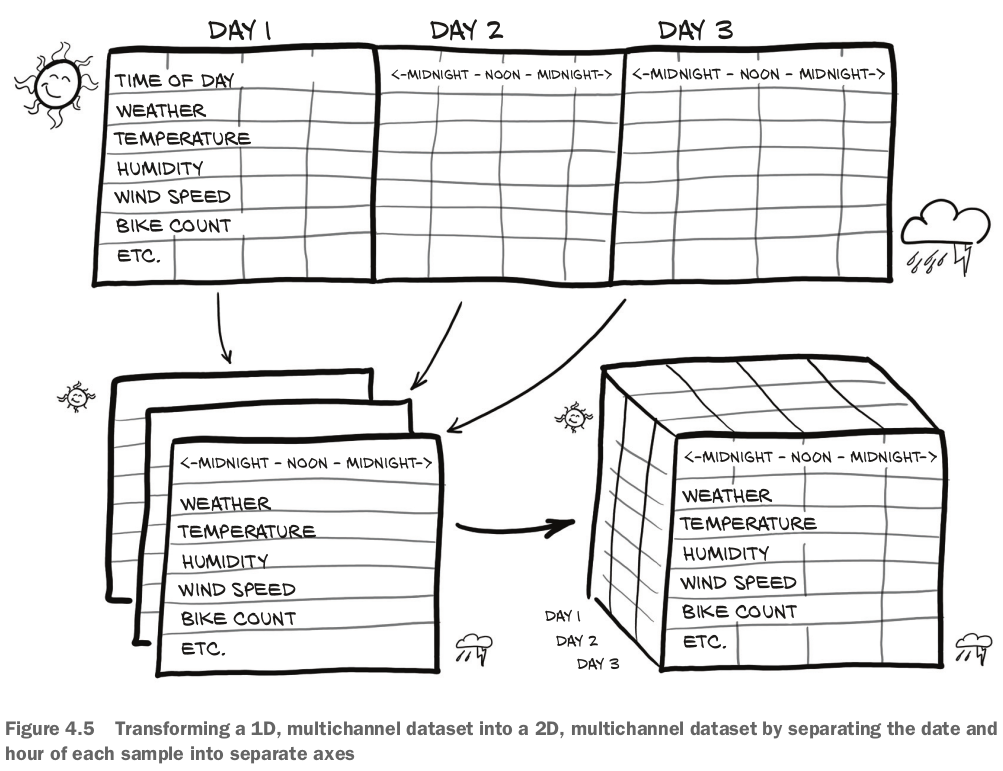

In [2]:
Image.open('img/bike-sharing-data-process-2020-12-14-21-08-39.png')

### 4.4.1 Adding a time dimension
- We want to change the row-per-hour(上記の図はtransposed version) organization so that we have **one axis that increases at a rate of one day per index increment**, and **another axis that represents the hour of the day (independent of the date)**.
    - The third axis will be our different columns of data (weather, temperature, and so on).

In [2]:
bikes_numpy = np.loadtxt('../data/p1ch4/bike-sharing-dataset/hour-fixed.csv',
                        dtype=np.float32,
                        delimiter=',',
                        skiprows=1,
                        converters={1: lambda x: float(x[8:10])})
bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

- `converter={1: lambda x: float(x[8:10])}`の意味：convert date strings to numbers corresponding to the day of the month in column 1.
- The existence of an ordering gives us the opportunity to exploit causal relationships(因果関係) across time.
    - For instance, it allows us to predict bike rides at one time based on the fact that it was raining at an earlier time.
- This neural network model will need to see a number of **sequences of values for each different quantity, such as ride count, time of day, temperature, and weather conditions**: *N* parallel sequences of size *C*.
    - *C* stands for *channel* and is the same as *column* for 1D data.
    - The *N* dimension represents the time axis, here one entry per hour.

### 4.4.2 Shaping the data by time period
- We might want to break up the two-year dataset into **wider observation periods**, like days.
- This way we'll have *N* collections of *C* sequences of length *L*.
- The *C* would remain our 17 channels, while *L* would be 24.
- We could also use `7x24=168` hour blocks to chunk by week instead. (**The number of rows must be a multiple of 24 or 168**. Also **cannot have gaps in the time series**)
- All we have to do to obtain our **daily hours dataset** is **view the same tensor in batches of 24 hours**.

In [3]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

- That's 17,520 hours, 17 columns.
- Now let's reshape the data to have 3 axes - **day, hour, and then 17 columns**:

In [4]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

- Our call to `view` requires us to **provide the new shape for the returned tensor**.
- (**大事**) We use `-1` as a **placeholder** for "**however many indexes are left, given the other dimensions and the original number of elements**".
- We now have *N* sequences of *L* hours in a day, for *C* channels.
    - To get to our desired *NxCxL* ordering, we need to transpose the tensor:

In [5]:
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

### 4.4.3 Ready for training
- The "weather situation" variable is ordinal.
- If we decided to go with categorial, we would turn the variable into a one-hot-coded vector and **concatenate the columns with the dataset**. もともとの1 columnが4 columnsになる。

In [6]:
first_day = bikes[:24].long() # サンプルとしてfirst dayを使う
weather_onehot = torch.zeros(first_day.shape[0], 4)
first_day[:,9]

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

- Then we **scatter ones into our matrix according to the corresponding level at each row**.

In [7]:
weather_onehot.scatter_(dim=1,
                       index=first_day[:,9].unsqueeze(1).long() - 1,
                       value=1.0)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])

- Last, we concatenate our matrix to our original dataset using the `cat` function:

In [8]:
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,
         16.0000,  1.0000,  0.0000,  0.0000,  0.0000]])

- Concatenated along the column dimension (that is, 1).
    - In other words, **the columns of the two datasets are stacked together**; or equivalently, **the new one-hot-encoded columns are appended to the original dataset**.
    - For `cat` to succeed, it is required that the tensors have the **same size along the other dimensions**.
    - でもここはもともとのweatherは消していないらしい。
- `daily_bikes`にも同様の処理を：(B, C, L), L=24.

In [9]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2])
daily_weather_onehot.shape

torch.Size([730, 4, 24])

- Scatter the one-hot encoding into the tensor in the *C* dimension:

In [10]:
daily_weather_onehot.scatter_(1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [11]:
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

- もう１つweatherの処理方法、continuous variableとしてみる：(下記のコードのため、この前weather消してなかったんだ)

In [12]:
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :] - 1.0) / 3.0

- Rescaling variables to the `[0.0, 1.0]` interval or the `[-1.0, 1.0]` interval is something **we'll want to do for all quantitative variables**.
- rescalingの方法１：map their range to `[0.0, 1.0]`.

In [13]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - temp_min) / (temp_max - temp_min))

- rescaling方法2：subtract the mean and divide by the standard deviation:

In [14]:
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp)) / torch.std(temp))

- In the latter case, our variable will have 0 mean and unitary standard deviation.
- If our variable were drawn from a Gaussian distribution, 68% of the samples would sit in the `[-1.0, 1.0]` interval.